In [17]:
import os 
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, auc, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


import joblib

In [3]:
data_path = '../data/processed/df_ready.csv'
df_prot = pd.read_csv(data_path)

In [6]:
X = df_prot.drop('is_ultra', axis=1)
y = df_prot['is_ultra']

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.25, random_state=42)

In [10]:
#baseline model

param_baseline = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)

random_base = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_baseline,
    n_iter=20,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

random_base.fit(X_train, y_train)

y_pred_base = random_base.predict(X_test)

baseline_accuracy = accuracy_score(y_test, y_pred_base)
baseline_f1score = f1_score(y_test, y_pred_base)
baseline_rocauc =  roc_auc_score(y_test, random_base.predict_proba(X_test)[:, 1])

print("Best Params: ", random_base.best_params_)
print("F1:", baseline_f1score)
print("AUC-ROC:",baseline_rocauc)
print("Accuracy:",baseline_accuracy)

Best Params:  {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20}
F1: 0.6308411214953271
AUC-ROC: 0.8121193577527174
Accuracy: 0.8034825870646766


In [11]:
# class_weight - balanced model

param_balanced = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

random_balanced = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_balanced,
    n_iter=20,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

random_balanced.fit(X_train, y_train)

y_pred_balanced = random_balanced.predict(X_test)

balanced_accuracy = accuracy_score(y_test, y_pred_balanced)
balanced_f1score = f1_score(y_test, y_pred_balanced)
balanced_rocauc =  roc_auc_score(y_test, random_balanced.predict_proba(X_test)[:, 1])

print("Best Params: ", random_balanced.best_params_)
print("F1:", balanced_f1score)
print("AUC-ROC:", balanced_rocauc)
print("Accuracy:",balanced_accuracy)

Best Params:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5, 'class_weight': 'balanced'}
F1: 0.6473214285714286
AUC-ROC: 0.8156671620479645
Accuracy: 0.8034825870646766


In [13]:
#Logistic Regression baseline model

lr = LogisticRegression(max_iter=1000, random_state=42)

param_dist_lr = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': np.logspace(-4, 4, 20),
    'solver': ['saga'],
    'l1_ratio': np.linspace(0, 1, 10)  # só usado se penalty='elasticnet'
}

random_search_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist_lr,
    n_iter=30,
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

random_search_lr.fit(X_train, y_train)

best_lr = random_search_lr.best_estimator_

y_pred_lr = best_lr.predict(X_test)
y_prob_lr = best_lr.predict_proba(X_test)[:, 1]

print("Best Params:", random_search_lr.best_params_)
print("F1-score:", f1_score(y_test, y_pred_lr))
print("AUC-ROC:", roc_auc_score(y_test, y_prob_lr))

Best Params: {'solver': 'saga', 'penalty': 'l1', 'l1_ratio': np.float64(0.4444444444444444), 'C': np.float64(1438.44988828766)}
F1-score: 0.32786885245901637
AUC-ROC: 0.6976789929189615


In [14]:
lr_balanced = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)


param_lr = {
    'C': np.logspace(-3, 3, 20),
    'penalty': ['l1', 'l2']
}

# 3. RandomizedSearchCV
lr_search = RandomizedSearchCV(
    estimator=lr_balanced,
    param_distributions=param_lr,
    n_iter=20,
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)


lr_search.fit(X_train, y_train)


y_pred_lr_bal = lr_search.predict(X_test)
f1_lr_bal = f1_score(y_test, y_pred_lr_bal)
roc_auc_lr_bal = roc_auc_score(y_test, lr_search.predict_proba(X_test)[:, 1])


print("Best Params:", lr_search.best_params_)
print("F1 Score:", f1_lr_bal)
print("AUC-ROC:", roc_auc_lr_bal)

Best Params: {'penalty': 'l2', 'C': np.float64(0.018329807108324356)}
F1 Score: 0.5185185185185185
AUC-ROC: 0.6907145146720284


In [15]:
#SVC model

svc = SVC(probability=True)

param_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# 4. RandomizedSearchCV
svc_search = RandomizedSearchCV(
    estimator=svc,
    param_distributions=param_svc,
    n_iter=10,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)


svc_search.fit(X_train, y_train)


y_pred_svc = svc_search.predict(X_test)
f1_svc = f1_score(y_test, y_pred_svc)
roc_auc_svc = roc_auc_score(y_test, svc_search.predict_proba(X_test)[:, 1])

print("Best Params:", svc_search.best_params_)
print("F1 Score:", f1_svc)
print("AUC-ROC:", roc_auc_svc)

Best Params: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
F1 Score: 0.5968586387434555
AUC-ROC: 0.8032607745432294


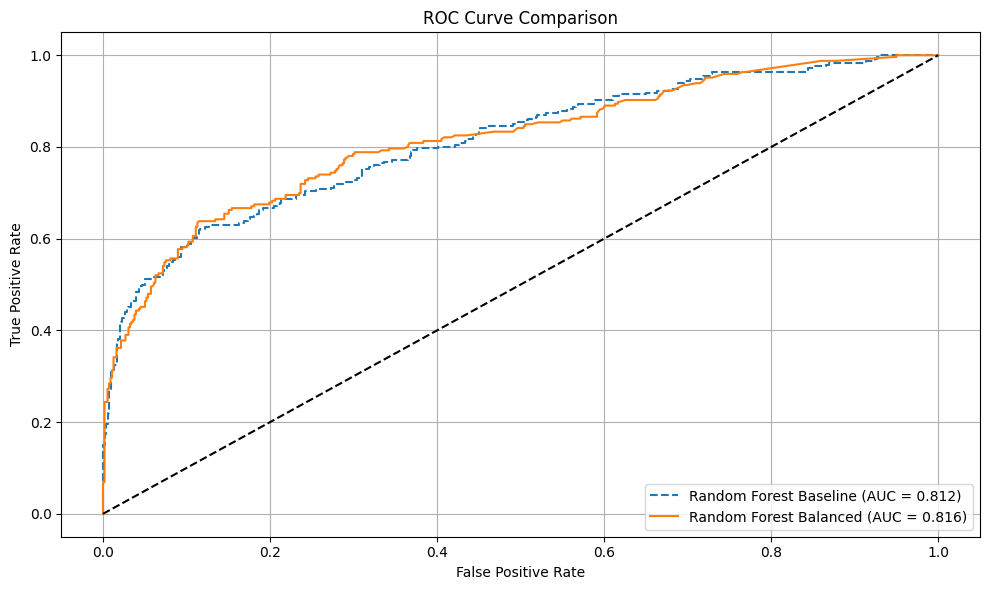

In [18]:
# rf baseline vs balanced

y_prob_base = random_base.predict_proba(X_test)[:, 1]
y_prob_balanced = random_balanced.predict_proba(X_test)[:, 1]


fpr_base, tpr_base, _ = roc_curve(y_test, y_prob_base)
fpr_bal, tpr_bal, _ = roc_curve(y_test, y_prob_balanced)


roc_auc_base = auc(fpr_base, tpr_base)
roc_auc_bal = auc(fpr_bal, tpr_bal)


plt.figure(figsize=(10,6))
plt.plot(fpr_base, tpr_base, label='Random Forest Baseline (AUC = {:.3f})'.format(roc_auc_base), linestyle='--')
plt.plot(fpr_bal, tpr_bal, label='Random Forest Balanced (AUC = {:.3f})'.format(roc_auc_bal))
plt.plot([0,1], [0,1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.savefig('../reports/fig_ROC_comparison.png', bbox_inches='tight')
plt.show()

# Model Comparison: Random Forest vs. SVC (Undersampling Strategy)

In this classification project, we evaluated two configurations of the Random Forest model to address the class imbalance problem:

Baseline Random Forest: trained on the original data without any specific adjustment for class imbalance.

Balanced Random Forest: same model, but with class_weight='balanced' to compensate for the imbalance.

# Key Findings
Both models achieved solid performance in terms of accuracy, F1-score, and AUC-ROC.

The Balanced Random Forest presented a slightly higher F1-score and AUC-ROC, indicating a better balance between precision and recall and a stronger discriminatory capacity.

Using class_weight='balanced' is a simple yet effective technique for handling imbalance without requiring data resampling, which keeps the original dataset intact.

Both models are interpretable through the .feature_importances_ attribute, which is useful for explaining the results to stakeholders.

# Conclusion
Considering the metrics and practical advantages, the Balanced Random Forest model is the preferred choice for the following reasons:

- Superior performance in F1-score and AUC-ROC

- Model interpretability, supporting transparency in decision-making

- No need for resampling, preserving the dataset’s integrity

- Efficient training time and ease of deployment

Thus, the balanced model is more suitable for both evaluation and potential real-world implementation.



In [19]:
best_rf_balanced = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=2,
    max_depth=5,
    class_weight='balanced',
    random_state=42
)

# Treinando o modelo com os dados completos de treino
best_rf_balanced.fit(X_train, y_train)

# Caminho para salvar o modelo
save_path = os.path.join("..", "models", "random_forest_balanced.pkl")

# Salvando com joblib
joblib.dump(best_rf_balanced, save_path)

print(f"Modelo salvo em: {save_path}")

Modelo salvo em: ..\models\random_forest_balanced.pkl
